(getting-started:tutorial-custom-functions)=
# Tutorial: Create a Custom Test Function

You may add an uncertainty quantification (UQ) test functions to UQTestFuns
such that they share the same interface like
the {ref}`built-in ones <getting-started:tutorial-built-in-functions>`.
There are two ways to add a new test function to UQTestFuns:

1. _Interactively_ within a given Python session;
   if not saved, the test function will be gone after a new session.
2. _Updating the package_ by implementing the function in a new module
   within the UQTestFuns package; the test function will available after
   importing the package.

In this tutorial, you'll learn how to add a test function interactively.
If you want to add a new test function as a Python module,
please refer to the {ref}`relevant section <development:adding-test-function-implementation>`
in the Developer's Guide.

In [1]:
import numpy as np
import uqtestfuns as uqtf

## Uncertainty quantification test functions revisited

In essence, an uncertainty quantification (UQ) test function
contains the following components:

- _an evaluation function_ that takes inputs and produces outputs;
  we can think of such functions as a blackbox
- _a probabilistic input model_ that specifies the input to 
  the blackbox function as a joint random variable;
  the results of a UQ analysis depend on this specification
- (optionally) _a set of parameters_ that completes
  the test function specification; these parameters once set are kept during
  the function evaluation (for example, flag, numerical tolerance,
  and time-step size).

When defining a new generic UQ test function, it's a good idea to think about 
the candidate test function in those three terms and be ready with their
specifications.

## Branin function

Suppose we want to add the two-dimensional Branin (or Branin-Hoo) function
as a test function {cite}`Dixon1978`.
The function is defined analytically as follows:

$$
\mathcal{M}(x_1, x_2) = a \left( x_2 - b x_1^2 + c x_1 - r \right)^2 + s \left(1 - t \right) \cos{(x_1}) + s
$$

where $x_1$ and $x_2$ are the input variables
and $\{ a, b, c, r, s, t \}$ are the parameters.

The input variables are defined in the table below.

|   No.    |  Name   | Distribution  | Parameters  |
|:--------:|:-------:|:-------------:|:-----------:|
|    1     |  $x_1$  |    uniform    | $[-5, 10]$  |
|    2     |  $x_2$  |    uniform    |  $[0, 15]$  |

The typical values for the parameters are shown in the table below.

| No.     | Parameter |          Value          |
|:-------:|:---------:|:-----------------------:|
| 1       |    $a$    |        $1.0$            |
| 2       |    $b$    | $\frac{5.1}{(2 \pi)^2}$ |
| 3       |    $c$    |     $\frac{5}{\pi}$     |
| 4       |    $r$    |           $6$           |
| 5       |    $s$    |          $10$           |
| 6       |    $t$    |    $\frac{1}{8 \pi}$    |

## Evaluation function

The first component of a test function is the evaluation function itself.
UQTestFuns requires for such a function to have at least the input array
as its first parameter.
When applicable, the parameters must be the second parameter of the function.
The Branin evaluation function can be defined as a Python function as follows:

In [2]:
def evaluate_branin(xx: np.ndarray, params: np.ndarray):
    """Evaluate the Branin function on a set of input values.
    
    Parameters
    ----------
    xx : np.ndarray
        2-Dimensional input values given by an N-by-2 array where
        N is the number of input values.
    params : np.ndarray
        The parameters of the Branin function;
        a 1-Dimensional array of length 5.
    
    Returns
    -------
    np.ndarray
        The output of the Branin function evaluated on the input values.
        The output is a 1-dimensional array of length N.    
    """
    yy = (
        params[0] * (xx[:, 1] - params[1] * xx[:, 0]**2 + params[2] * xx[:, 0] - params[3])**2
        + params[4] * (1 - params[5]) * np.cos(xx[:, 0]) 
        + params[4]
    )
    
    return yy

## Input and parameters

The second and third components of a test function are
the (probabilistic) input specification and the parameters.
The input specification of the Branin function consists of
two independent uniform random variables with different bounds.
In UQTestFuns, a probabilistic input model is represented by `ProbInput` class
and an instance of it can be defined as follows:

In [3]:
# Define a list of marginals
marginals = [
    uqtf.UnivDist(distribution="uniform", parameters=[-5, 10], name="x1"),
    uqtf.UnivDist(distribution="uniform", parameters=[0, 15], name="x2"),
]
# Create a probabilistic input
my_input = uqtf.ProbInput(marginals=marginals, name="Branin-Input")

To verify if the instance has been created successfully,
print it out to the terminal:

In [4]:
print(my_input)

Name         : Branin-Input
Spatial Dim. : 2
Description  : None
Marginals    :

  No.   Name    Distribution    Parameters    Description
-----  ------  --------------  ------------  -------------
    1    x1       uniform        [-5 10]
    2    x2       uniform        [ 0 15]

Copulas      : None


Finally, the parameters of the Branin function defined above can be defined
as a NumPy array as follows:

In [5]:
my_params = np.array([1.0, 5.1 / (2 * np.pi)**2, 5 / np.pi, 6, 10, 1 / (8 * np.pi)])

```{note}
The parameters can practically be of any Python data type.
They only depend on how they are going to be consumed
by the specified evaluation function.
In other words, you have full control on how to define the parameters.
```

## Creating a test function

```{margin}
Once again, a UQ test function consists of an evaluation function,
a probabilistic input model, and (optionally) a set of parameters.
```

The evaluation function, probabilistic input, and parameters are combined
to make a test function via the `UQTestFun` class.
An instance of the class for the Branin function is written as follows:

In [6]:
my_testfun = uqtf.UQTestFun(
  evaluate=evaluate_branin,
  prob_input=my_input,
  parameters=my_params,
  name="Branin function",
)

Print the resulting instance to the terminal to verify:

In [7]:
print(my_testfun)

Name              : Branin function
Spatial dimension : 2


Congratulations! You've successfully created a test function instance of
the Branin function inside a Python session.
This instance can be evaluated as a usual function.
Below are the surface and contour plots of the test function;
both require function evaluation on the grid.

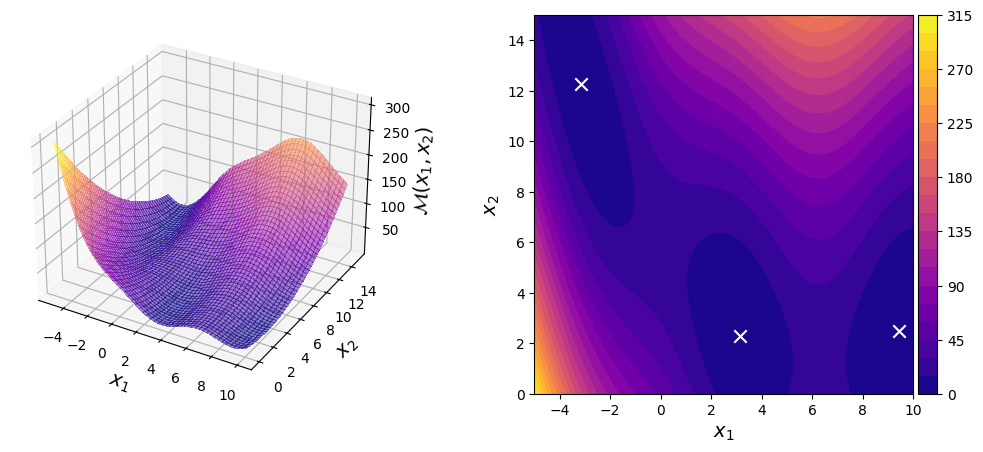

In [8]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

# --- Create a 2-D grid
xx_1 = np.linspace(
    my_input.marginals[0].lower, my_input.marginals[0].upper, 2000
)
xx_2 = np.linspace(
    my_input.marginals[1].lower, my_input.marginals[1].upper, 2000
)
mesh_2d = np.meshgrid(xx_1, xx_2)
xx_2d = np.array(mesh_2d).T.reshape(-1, 2)
yy_2d = my_testfun(xx_2d)

# --- Create the plots
fig = plt.figure(figsize=(11, 5))

# Surface
axs_1 = plt.subplot(121, projection='3d')
axs_1.plot_surface(
    mesh_2d[0],
    mesh_2d[1],
    yy_2d.reshape(2000, 2000).T,
    cmap="plasma",
    linewidth=0,
    antialiased=False,
    alpha=0.5
)
axs_1.set_xlabel("$x_1$", fontsize=14)
axs_1.set_ylabel("$x_2$", fontsize=14)
axs_1.set_zlabel("$\mathcal{M}(x_1, x_2)$", fontsize=14)

# Contour
axs_2 = plt.subplot(122)
cf = axs_2.contourf(
    mesh_2d[0], mesh_2d[1], yy_2d.reshape(2000, 2000).T, 20, cmap="plasma"
)
axs_2.set_xlabel("$x_1$", fontsize=14)
axs_2.set_ylabel("$x_2$", fontsize=14)
divider = make_axes_locatable(axs_2)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(cf, cax=cax, orientation='vertical')
axs_2.axis('scaled')

# Optimum value locations
axs_2.scatter(
    np.array([-np.pi, np.pi, 9.42478]), np.array([12.275, 2.275, 2.475]),
    s=80,
    marker="x",
    color="white"
)

fig.tight_layout(pad=3.0)

The Branin function is a test function typically used for
testing optimization algorithms.
Shown in the contour plot above are the locations of
the three global optima of the function.

## Concluding remarks

The test function created above only persists in the current Python session.
To use the same Branin test function in another session,
you can either repeat the same procedure (for example, via a script)
or save it into an object in the disk and load it in the new session.

Alternatively, you can extend UQTestFuns directly by specifying
the test function inside its own module.
This way, once UQTestFuns is loaded you can construct the test function
like any other built-in test function.
For example, if you somehow name the test function `Branin` then:

```python
my_testfun = uqtf.Branin()
```

will construct an instance of the Branin function using
the default input and parameter values.

You can find a guide on how to do this in more detail
in the {ref}`relevant section <development:adding-test-function-implementation>`
of the Developer's Guide.

```{bibliography}
:style: plain
:filter: docname in docnames
```